
# TP3 — Thresholding, Binarization & Blob Analysis

**Auteur :** Loann KAIKA  

In [5]:
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline

base_dir = r"C:/Users/loann/Desktop/cv2/Images"
candidates = ["rice.tif", "coins.png", "ic.tif", "formes.png"]


## 1) Seuillage manuel global

On lit une image en niveaux de gris et on trace son histogramme.
On applique un seuillage global avec un seuil $T$ fixé :

$$
B(x,y) =
\begin{cases}
255 & \text{si } I(x,y) > T \\
0 & \text{sinon}
\end{cases}
$$

* L’axe **X** de l’histogramme correspond aux intensités \[0–255].
* L’axe **Y** correspond au nombre de pixels.
  Ce seuil sépare objet et fond si l’histogramme est bimodal (deux pics).



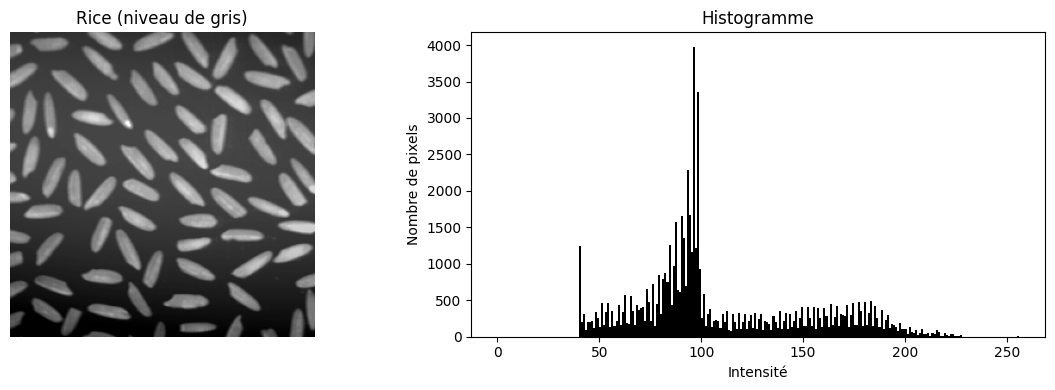

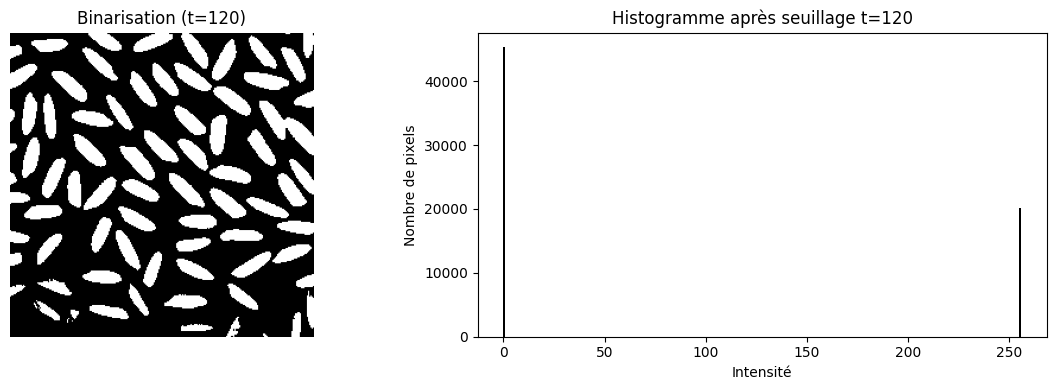

In [8]:
def load_gray(filename):
    path = str(Path(base_dir)/filename)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"[ERREUR] Impossible de charger {path}")
        H, W = 256, 256
        x = np.linspace(0, 255, W, dtype=np.uint8)
        img = np.tile(x, (H, 1))
    return img

def manual_threshold(img, t=128):
    return np.where(img > t, 255, 0).astype(np.uint8)

img = load_gray("rice.tif")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(img, cmap="gray")
axes[0].set_title("Rice (niveau de gris)")
axes[0].axis("off")
axes[1].hist(img.ravel(), bins=256, range=(0,256), color="black")
axes[1].set_title("Histogramme"); axes[1].set_xlabel("Intensité"); axes[1].set_ylabel("Nombre de pixels")
plt.tight_layout(); plt.show()

t = 120
bin_img = manual_threshold(img, t)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(bin_img, cmap="gray")
axes[0].set_title(f"Binarisation (t={t})")
axes[0].axis("off")
axes[1].hist(bin_img.ravel(), bins=256, range=(0,256), color="black")
axes[1].set_title(f"Histogramme après seuillage t={t}")
axes[1].set_xlabel("Intensité"); axes[1].set_ylabel("Nombre de pixels")
plt.tight_layout(); plt.show()



## 2) `cv.threshold` et seuillage adaptatif

* La fonction `cv.threshold` applique un **seuil global** identique sur toute l’image.
* La fonction `cv.adaptiveThreshold` calcule un **seuil local** pour chaque pixel à partir de son voisinage :

$$
T(x,y) = \overline{I}_{\mathcal{N}(x,y)} - C
$$

où $\overline{I}_{\mathcal{N}(x,y)}$ est la moyenne (ou une moyenne pondérée gaussienne) des intensités autour du pixel, et $C$ est une constante soustraite.

Ainsi, le seuillage adaptatif corrige les **variations d’éclairage** et permet de segmenter correctement les objets même si l’illumination est non uniforme.


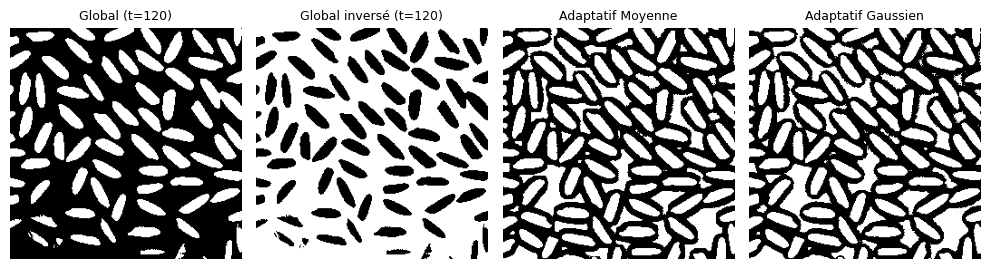

In [13]:
_, th_bin = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY)
_, th_inv = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY_INV)

th_mean = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                cv2.THRESH_BINARY, blockSize=15, C=5)
th_gauss = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY, blockSize=25, C=5)

fig, axes = plt.subplots(1, 4, figsize=(10, 3))
axes[0].imshow(th_bin, cmap="gray")
axes[0].set_title("Global (t=120)", fontsize=9)
axes[0].axis("off")

axes[1].imshow(th_inv, cmap="gray")
axes[1].set_title("Global inversé (t=120)", fontsize=9)
axes[1].axis("off")

axes[2].imshow(th_mean, cmap="gray")
axes[2].set_title("Adaptatif Moyenne", fontsize=9)
axes[2].axis("off")

axes[3].imshow(th_gauss, cmap="gray")
axes[3].set_title("Adaptatif Gaussien", fontsize=9)
axes[3].axis("off")

plt.tight_layout()
plt.show()


## 3) Seuillage d'Otsu

La méthode d'Otsu choisit automatiquement le seuil de binarisation en se basant sur l'histogramme de l'image.
Elle cherche la valeur qui sépare le mieux les pixels en **deux classes distinctes** : le fond et les objets.

En pratique, Otsu fonctionne bien lorsque l'histogramme est **bimodal** (deux pics), car il positionne le seuil entre ces deux modes.


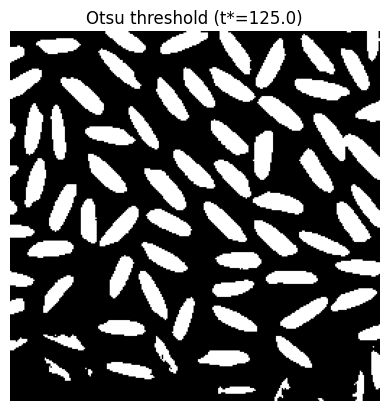

In [12]:
t_otsu, th_otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.imshow(th_otsu, cmap="gray")
plt.title(f"Otsu threshold (t*={t_otsu:.1f})")
plt.axis("off")
plt.show()



## 4) Comparaison des méthodes

* **Seuil manuel** : on fixe $T$ arbitrairement → dépend du choix de l’utilisateur.
* **Seuil global (`cv.threshold`)** : applique le même seuil partout → fonctionne si l’éclairage est homogène.
* **Seuil adaptatif** : calcule un seuil local en fonction de l’intensité moyenne autour de chaque pixel → utile en cas d’éclairage non uniforme.
* **Otsu** : choisit automatiquement le seuil qui sépare le mieux l’histogramme en deux classes (objet/fond).

En résumé :

$$
T_\text{global} = \text{valeur fixe}, \quad 
T_\text{local}(x,y) = \overline{I}_{\mathcal{N}(x,y)} - C
$$

Sur l’image `rice.png`, les méthodes adaptative et Otsu donnent de meilleurs résultats que le seuil manuel, car elles s’adaptent mieux à l’illumination.


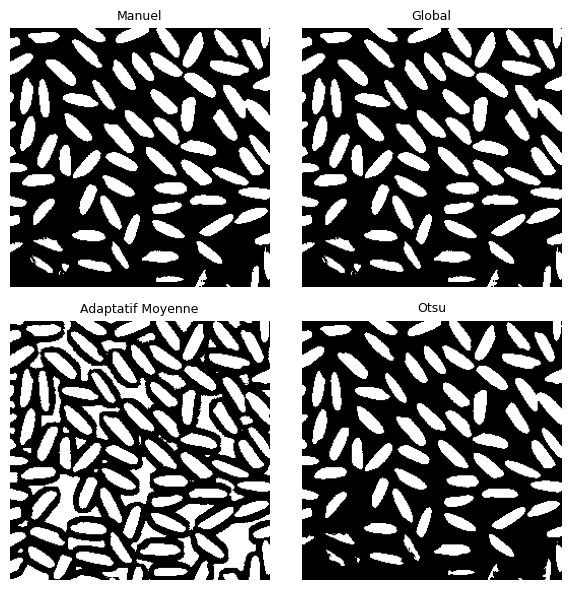

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

axs[0,0].imshow(bin_img, cmap="gray")
axs[0,0].set_title("Manuel", fontsize=9)
axs[0,0].axis("off")

axs[0,1].imshow(th_bin, cmap="gray")
axs[0,1].set_title("Global", fontsize=9)
axs[0,1].axis("off")

axs[1,0].imshow(th_mean, cmap="gray")
axs[1,0].set_title("Adaptatif Moyenne", fontsize=9)
axs[1,0].axis("off")

axs[1,1].imshow(th_otsu, cmap="gray")
axs[1,1].set_title("Otsu", fontsize=9)
axs[1,1].axis("off")

plt.tight_layout()
plt.show()


## 5) Connected Components (étiquetage)

Après avoir binarisé l’image, on peut appliquer un **étiquetage des composantes connexes**.
Chaque groupe de pixels blancs (valeur 255) reliés entre eux est identifié comme un objet distinct et reçoit une étiquette unique.

* Fonction utilisée : `cv2.connectedComponents`.
* Résultat : une image de labels (matrice d’entiers) que l’on peut coloriser pour visualiser les différents objets.

Cela permet de **compter le nombre d’objets** et de les distinguer visuellement.


Formes.png → 4 labels (incluant fond)


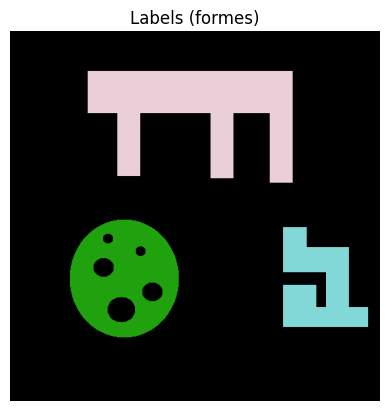

In [ ]:
img_formes = load_gray("formes.png")
_, formes_bin = cv2.threshold(img_formes, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

N, labels = cv2.connectedComponents(formes_bin)
print("Formes.png →", N, "labels (incluant fond)")

def label2rgb(labels):
    n = labels.max()+1
    rng = np.random.default_rng(0)
    colors = rng.integers(0,255,(n,3),dtype=np.uint8)
    colors[0] = 0
    return colors[labels]

show(cv2.cvtColor(label2rgb(labels), cv2.COLOR_BGR2RGB), "Labels (formes)")


## 6) Connected Components with Stats

La fonction `cv2.connectedComponentsWithStats` fournit, en plus de l’étiquette de chaque objet :

* $x, y, w, h$ : coordonnées et dimensions de la boîte englobante,
* `area` : surface (nombre de pixels de l’objet),
* `centroid` : coordonnées du centre de gravité.

Cela permet une **analyse quantitative** des objets détectés : taille, position, répartition.


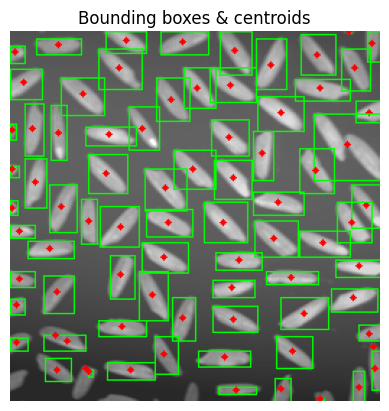

In [ ]:
N, labels, stats, centroids = cv2.connectedComponentsWithStats(th_otsu)

vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
for i in range(1, N):
    x,y,w,h,area = stats[i]
    cx, cy = centroids[i]
    cv2.rectangle(vis, (x,y), (x+w,y+h), (0,255,0), 1)
    cv2.circle(vis, (int(cx),int(cy)), 2, (0,0,255), -1)

show(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB), "Bounding boxes & centroids")



## 7) Influence du seuil sur les aires

En faisant varier le seuil $T$, on peut observer :

* la **moyenne** et la **médiane** des aires des objets détectés,
* l’**histogramme des aires** pour un seuil donné.

Quand $T$ augmente, les objets apparaissent plus petits car moins de pixels dépassent le seuil, et certains disparaissent complètement s’ils sont trop sombres.
Cela montre que le choix de $T$ a un impact direct sur la détection et la mesure des objets.

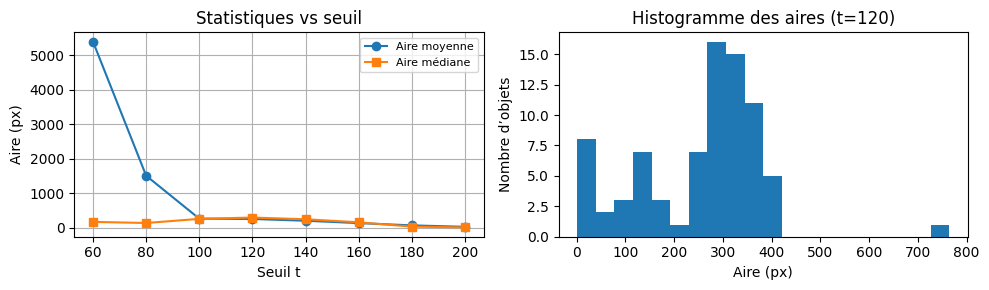

In [6]:
def composantes_aires(bin_img):
    N, _, stats, _ = cv2.connectedComponentsWithStats(bin_img)
    return stats[1:, 4] if N > 1 else np.array([], dtype=np.int32)

seuils = range(60, 201, 20)
moyennes, medianes = [], []

for t0 in seuils:
    binaire = np.where(img > t0, 255, 0).astype(np.uint8)
    aires = composantes_aires(binaire)
    moyennes.append(aires.mean() if aires.size else 0)
    medianes.append(np.median(aires) if aires.size else 0)

t_affiche = 120
binaire_affiche = np.where(img > t_affiche, 255, 0).astype(np.uint8)
aires = composantes_aires(binaire_affiche)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

axes[0].plot(seuils, moyennes, 'o-', label="Aire moyenne")
axes[0].plot(seuils, medianes, 's-', label="Aire médiane")
axes[0].set_xlabel("Seuil t"); axes[0].set_ylabel("Aire (px)")
axes[0].legend(fontsize=8); axes[0].grid(True)
axes[0].set_title("Statistiques vs seuil")

axes[1].hist(aires, bins=20)
axes[1].set_title(f"Histogramme des aires (t={t_affiche})")
axes[1].set_xlabel("Aire (px)"); axes[1].set_ylabel("Nombre d’objets")

plt.tight_layout()
plt.show()
